In [33]:
import pandas as pd
import numpy as np
import csv
import re
import sys

In [34]:
names = ['Text']
d1 = pd.read_table('samp.pt-br', header=None, delimiter=None, names=names, engine=None)

d1['lang'] = 0
d1.head()

/home/flame/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


,Text,lang
0,"Segundo a Apeoesp, o secretário da Educação, C...",0
1,"E as falcatruas e fraudes em todos os níveis, ...",0
2,Rebeldes podem soltar refém,0
3,"Apesar de arriscado, o estilo reflete o moment...",0
4,Essa nova versão de «O Fugitivo» também mostro...,0


In [35]:
names = ['Text']
d2 = pd.read_csv('samp.pt-pt', header=None, delimiter=None, names=names, engine='python-fwf')
d2['lang'] = 1

d2.head()

,Text,lang
0,Eu continuo a acreditar na justiça .,1
1,O torneio decorre até ao próximo dia 20 e os e...,1
2,Os Vancouver Grizzlies protagonizaram a surpre...,1
3,Um recente artigo publicado no « Novo Jornal »...,1
4,"« Estamos a fazer esforços para que , ainda no...",1


In [36]:
print(len(d1), len(d2))

47554 50000


In [37]:
dt = [d1, d2]
df = pd.concat(dt)

df = df.sample(frac=1).reset_index(drop=True)

In [38]:
df.head()

,Text,lang
0,"No final , Cason , Christie e Lewis abraçaram-...",1
1,Achamos que esgotamos o que tínhamos que fazer...,0
2,O imediatismo cega as pessoas e as leva a conf...,0
3,"Na greve, 3 milhões de pessoas ficaram sem tra...",0
4,"Depois de , aquando do debate entre Carlos Can...",1


In [39]:
len(df)

97554

In [40]:
df['lang'].value_counts()

1    50000
0    47554
Name: lang, dtype: int64

In [41]:
# Preprocessing of the text, took care of basic pre-processing task only.

def processSent(sent):
    # To lowercase
    sent = sent.lower()
    #remove @username
    sent = re.sub(r'@(\w+)','',sent)
    
    # Remove hashtags
    sent = re.sub(r'#(\w+)', '', sent)
    
    # Remove Punctuation and split 's, 't, 've with a space for filter    
    sent = re.sub(r"[-()\"«/;»:<>{}`+=~|.!&?',]", "", sent)
    
    # remove the numerical values
    sent = re.sub(r"(\s\d+)","",sent) 
    
    # Remove HTML special entities (e.g. &amp;)
    sent = re.sub(r'\&\w*;', '', sent)
    
    # Remove tickers
    sent = re.sub(r'\$\w*', '', sent)
    
    # Remove hyperlinks
    sent = re.sub(r'https?:\/\/.*\/\w*', '', sent)
   
    # Remove whitespace (including new line characters)
    sent = re.sub(r'\s\s+', ' ', sent)
   
    # Remove single space remaining at the front of the sent.
    sent = sent.lstrip(' ') 
    
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    sent = ''.join(c for c in sent if c <= '\uFFFF') 
    
    return sent

In [42]:
data = df.copy()
data['Text'] = data['Text'].apply(processSent)
print(data.head())

                                                Text  lang
0  no final cason christie e lewis abraçaramse ma...     1
1  achamos que esgotamos o que tínhamos que fazer...     0
2  o imediatismo cega as pessoas e as leva a conf...     0
3  na greve milhões de pessoas ficaram sem transp...     0
4  depois de aquando do debate entre carlos canda...     1


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
train = list(data['Text'])
# test = list(dft['Text'])
# corpus = train+test
corpus = train
tfidf = TfidfVectorizer(max_features = 6000) 
tfidf.fit(corpus)
tfidf_features = tfidf.transform(corpus)
# tfidf_features_test = tfidf.transform(test)

print(tfidf_features.shape)

(97554, 6000)


In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC


# Converting the labels from strings to binary (if we have string 'lang' labels)
label = data['lang']
le = LabelEncoder()
le.fit(label)
label = le.transform(label)


import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
# from sklearn import cross_validation

# # Taking 80/20 train test split
# train_percent = 0.8
# train_cutoff = int(np.floor(train_percent*len(data['Text']) ) )
X_train,X_test, Y_train, Y_test = train_test_split(tfidf_features, label, test_size=0.2, random_state=42)
# X_train = tfidf_features_train
# Y_train = label

# X_test = tfidf_features_test

# X_train,X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print("Train: ", (X_train.shape), (Y_train.shape))
print("Test: ", (X_test.shape), (Y_test.shape))

Train:  (78043, 6000) (78043,)
Test:  (19511, 6000) (19511,)


In [45]:
tfidf_model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
# 81.5%

# tfidf_model = MultinomialNB()  
# 78.2%
tfidf_model.fit(X_train, Y_train)
tfidf_prediction = tfidf_model.predict(X_test)


results = pd.DataFrame(index = ['Word Embedding', 'TF-IDF'], 
          columns = ['Precision', 'Recall', 'F1 score', 'support']
          )
results.loc['TF-IDF'] = precision_recall_fscore_support(
          Y_test, 
          tfidf_prediction, 
          average = None
          )

/home/flame/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [46]:
print(results.loc['TF-IDF'])
Y_pred = tfidf_prediction

k = 19511
dim = 2

P1 = np.zeros((k,dim), dtype=np.float32)
P2 = np.zeros((k,dim), dtype=np.float32)

for i in range(k):
    P1[i][int(Y_test[i])]=1.0
    P2[i][int(Y_pred[i])]=1.0

print(P1, P2)

Precision    [0.8140391496527047, 0.8240583474872615]
Recall         [0.81455349620893, 0.8235646530204693]
F1 score     [0.8142962417096536, 0.8238114262884538]
support                                 [9496, 10015]
Name: TF-IDF, dtype: object
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]] [[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


0 9502
1 10009
[[7735 1767]
 [1761 8248]]


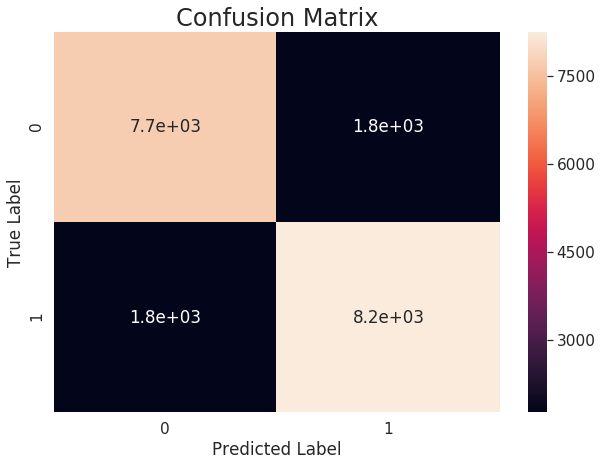

In [47]:
P1 = np.argmax(P1, axis=1)
for ix in range(2):
    print(ix, confusion_matrix(np.argmax(P2, axis=1), P1)[ix].sum())
cm = confusion_matrix(np.argmax(P2, axis=1), P1)
print(cm)

import seaborn as sn
import matplotlib.pyplot as plt
 
df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True)
sn.set_context("poster")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
# plt.savefig('gdrive/My Drive/PolEval/confusionMatrix2.png')
plt.show()

In [48]:
target_names = ['Pt-br', 'Pt-pt']
print(classification_report(np.argmax(P2, axis=1), P1, target_names=target_names))
from sklearn.metrics import accuracy_score
print(accuracy_score(np.argmax(P2, axis=1), P1, normalize=True))

              precision    recall  f1-score   support

       Pt-br       0.81      0.81      0.81      9502
       Pt-pt       0.82      0.82      0.82     10009

   micro avg       0.82      0.82      0.82     19511
   macro avg       0.82      0.82      0.82     19511
weighted avg       0.82      0.82      0.82     19511

0.8191789247091384
